# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

# Lab 05 probabilistic noise suppression methods
2023/04/14

- attached: 
    1. [`lab05.pdf`](lab05.pdf)
    1. [`lab05.md`](lab05.md)

----
# import packages, define analysis parameters and draw parameters, audio file preparation, etc.

In [1]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

# display wav files
import IPython

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

---
### 이전 lab 들에서 정의한 함수들

In [4]:
# draw spectrogram
from gjdrawspectrogram3 import drawspectrogram3

# linear phase FIR filter design from magnitudes of the frequency components
from gjfiroverlapadd import getLPHFIRFFT

# trapezoidal overlap add for FIR filtering
from gjfiroverlapadd import firoverlapadd

# save audio in wav format
import gjwavfile as wav

---
### load speech and noise

오디오 파일들의 경로 정의

In [5]:
audioinputpath = '../audio'
inputpath = 'input'
outpath = 'out'

# add '/' if path is not a null string
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file

In [6]:
speechfile = addpath(audioinputpath, 'gjang-kdigits0-3.wav')
noisefile  = addpath(audioinputpath, 'car.wav')
wnoisefile  = addpath(audioinputpath, 'car_wideband.wav')   # 넓은 주파수 대역에 분포한 잡음

__load files in windows wav format__
- `librosa.load()`는 $-1 \sim 1$
- 읽어들인 sampling frequency $F_s$ 를 이용하여 frame size $N_f$, shift size $N_s$를 계산한다.
- FFT (fast Fourier transform) 크기는 $N_f$ 보다 크거나 같은 2의 거듭제곱으로 FFT 크기 $N_{FFT}$ 을 정의함
$$ N_{FFT} = 2^{\lceil \log_{2} N_{f} \rceil} $$

In [7]:
# load audio files with Librosa
speech, Fs = librosa.load(speechfile, sr=None, mono='True')
noise, _ = librosa.load(noisefile, sr=Fs, mono='True')
wnoise, _ = librosa.load(wnoisefile, sr=Fs, mono='True')
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(speechfile, speech.shape, speech)
print(noisefile, noise.shape, noise)
print(wnoisefile, wnoise.shape, wnoise)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
hNo = NFFT//2+1
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d, hNo = %d' % (Fs, Ns, Nf, NFFT, hNo))

../audio/gjang-kdigits0-3.wav (37952,) [-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04]
../audio/car.wav (175745,) [-0.01342773 -0.0222168  -0.02905273 ... -0.0390625  -0.03930664
 -0.04086304]
../audio/car_wideband.wav (175745,) [-0.05984497 -0.14807129 -0.14700317 ... -0.10241699 -0.10253906
 -0.09594727]
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512, hNo = 257


array([[  3.43608106,   6.52668654,   6.4201852 , ...,  -3.22208712,
        -12.109726  ,  -4.36789082],
       [ 16.55197942,  18.74696753,  18.31199222, ...,  19.0139984 ,
         19.83277802,  20.39343026],
       [ 17.40766666,  20.26121289,  22.16222055, ...,  23.42829917,
         24.75091936,  23.02823122],
       ...,
       [-38.4390941 , -34.7011153 , -44.66451486, ..., -43.87783998,
        -66.51596708, -37.96959437],
       [-39.0657465 , -35.03712344, -45.91154493, ..., -44.16382711,
        -67.00779024, -38.02013985],
       [-38.56792469, -34.81379091, -44.87832819, ..., -43.44395922,
        -78.27134367, -38.10852218]])

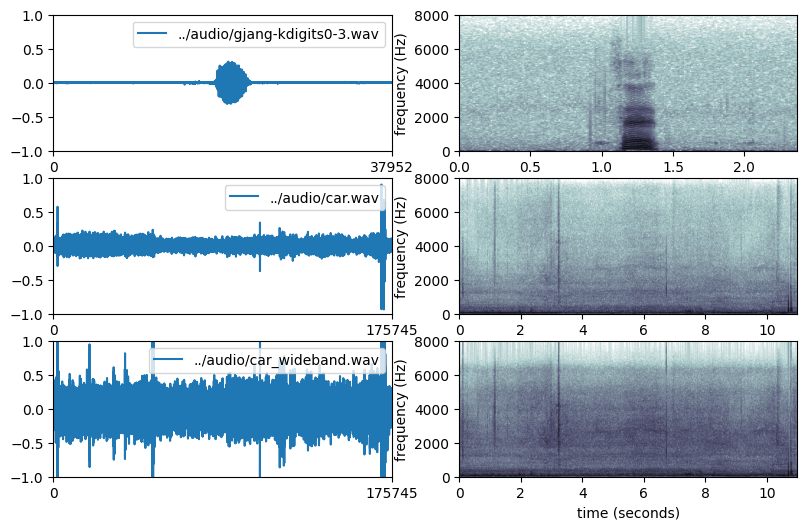

In [8]:
plt.figure(figsize=FIG_SIZE*np.array([1.2,2.0]))

def plotsignal(s, lab):
    plt.plot(s, label=lab)
    plt.xlim(0,len(s)); plt.ylim(-1,1)
    plt.xticks([0, len(s)])
    plt.legend(loc='upper right')

plt.subplot(3,2,1)
plotsignal(speech, speechfile)
plt.subplot(3,2,2)
drawspectrogram3(speech, Fs, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)

plt.subplot(3,2,3)
plotsignal(noise, noisefile)
plt.subplot(3,2,4)
drawspectrogram3(noise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)

plt.subplot(3,2,5)
plotsignal(wnoise, wnoisefile)
plt.subplot(3,2,6)
drawspectrogram3(wnoise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)

In [9]:
IPython.display.Audio(speechfile)

In [10]:
IPython.display.Audio(noisefile)

In [11]:
IPython.display.Audio(wnoisefile)

__generate noisy speech with various SNRs__
- 음성과 잡음의 상대적 크기에 따라 잡음의 효과를 time domain, spectrogram, 그리고 들어서 확인해 본다.
- mixed input $x[t]$ 를 다음과 같이 생성한다.
$$ x[t] = s[t] + 10^{-r/20} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$

In [12]:
def generate_mixed_signals(speech, noise, SNRs, isdraw=False, fname_header='mix'):
    std_s = np.sqrt(np.mean(speech**2))
    std_n = np.sqrt(np.mean(noise[:len(speech)]**2))
    mixedSig = []
    for snr in mixsnrs:
        gain = np.power(10, -snr/20)
        gn = noise[:len(speech)]/std_n*std_s*gain
        m = speech + gn
        mixedSig.append(m)
        print('Target SNR = %.0f dB, gain = %.2f, Mixing SNR=%.2f' % (snr, gain,10*np.log10(np.sum(speech**2)/np.sum(gn**2))))

        # save the mixed
        fname = addpath(inputpath, '%s%.fdb.wav' % (fname_header,snr))
        wav.writewav(fname, Fs, m, maxval=1.0)

        # draw
        if isdraw:
            plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
            plt.subplot(1,2,1)
            xscale = np.arange(len(gn))/Fs
            plt.plot(xscale,gn); plt.plot(xscale,speech); plt.xlim(0,len(speech)/Fs); plt.ylim(-0.5,0.5)  #; plt.xticks([])
            plt.title('SNR = %.0f dB' % (snr))
            plt.subplot(1,2,2)
            drawspectrogram3(m, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)

    return mixedSig

In [13]:
mixsnrs = np.array([20, 10, 0, -10])
mixedSig1 = generate_mixed_signals(speech, noise, mixsnrs, isdraw=False, fname_header='nbn_mix')
mixedSig2 = generate_mixed_signals(speech, wnoise, mixsnrs, isdraw=False, fname_header='wbn_mix')

Target SNR = 20 dB, gain = 0.10, Mixing SNR=20.00
Target SNR = 10 dB, gain = 0.32, Mixing SNR=10.00
Target SNR = 0 dB, gain = 1.00, Mixing SNR=-0.00
Target SNR = -10 dB, gain = 3.16, Mixing SNR=-10.00
Target SNR = 20 dB, gain = 0.10, Mixing SNR=20.00
Target SNR = 10 dB, gain = 0.32, Mixing SNR=10.00
Target SNR = 0 dB, gain = 1.00, Mixing SNR=-0.00
Target SNR = -10 dB, gain = 3.16, Mixing SNR=-10.00


---
# Programming assignments: implementating probabilistic noise suppression methods

---
## 1. probabilstic voice activity detection (VAD) for noise spectrum estimation
- fixed thresholding 으로 noise 구간을 구하면 noise 의 크기에 크게 
    영향받을 수 밖에 없다. 따라서 noise 구간을 유연하게 추정할 수 있는
    (adaptive thresholding) 확률 모델을 사용하여 본다.

1. 확률 모델을 이용하여 probabilistic voice activity detection 수행
2. 각 frame 별로 noise 확률 계산 - find P(voice|y), y 는 한 frame 
3. (deterministic decision) 확률값을 thresholding 하여 binary classification, 그리고 검출된 noise frame 들의 평균 제곱 Fourier 성분으로 noise spectrum 예측 
4. (soft decision and maximum a posteriori estimation) 각 frame 별로 posterior probability ( P( voice | y ) ) 를 계산함. 그리고 noise spectrum 을 posterior probability로 weighted estimation 한다.  E[N] = sum (1-P(v|y)) y
5. 두 가지 방법(deterministic/soft)으로 추정한 noise spectrum 으로 suppression 한 결과 비교 
6. noise 차감은 lab04 의 time-domain Wiener filtering 이용

---
## 2. time domain VAD

1. time domain signal 에 대해서 dual Gaussian mixture model 을 이용하여 probabilistic voice activity detection 
2. speech 의 크기가 noise 의 크기보다 작다고 가정하고 
작은 Gaussian 을 noise 분포로 가정 
3. P(noise|y) = p(noise) p(y|noise), y 는 한 frame

### Speech and noise distribution
- raw signal 자체의 확률 분포 $p(x)$, $p(n)$ 를 그려본다. 

In [14]:
# 확률 분포를 relative histogram 으로 그린다.
def plot_relative_hist(x, bins=10, lab=''):
    # plt.hist(x, bins=50)   # 개수를 보여준다. 확률은 아래와 같이 
    counts, bins = np.histogram(x, bins=bins)
    fcounts = counts / len(x)
    plt.stairs(fcounts, bins, label=lab)
    return fcounts

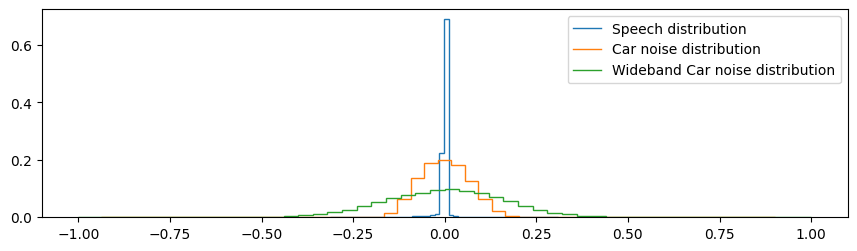

In [15]:
plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
plot_relative_hist(speech, bins=50, lab='Speech distribution')
plot_relative_hist(noise, bins=50, lab='Car noise distribution')
plot_relative_hist(wnoise, bins=50, lab='Wideband Car noise distribution')
plt.legend(loc='upper right')

- 음성의 pdf $f_{x}(x)$ 는 매우 peaky 하고 long tail을 가진 Laplacian 을 따른다.
$$ f_{X} (y) = \frac{1}{\sqrt{2} \sigma_{X}} \exp \left[ - \sqrt{2} \frac{|y-\mu_{X}|}{\sigma_{X}} \right] $$

- noise pdf $f_{N} (n)$ 는 bell-shaped Gaussian distribution 을 따른다.
$$ f_{N} (y) = \frac{1}{\sqrt{2 \pi } \sigma_{N}} \exp \left[ - \frac{(y-\mu_{N})^{2}}{\sigma_{N}^2} \right] $$

- mixed signal 의 분포 $p(y=x+n)$ 도 그려보자
    - SNR 10, 0, -10 dB

Text(0.5, 1.0, '../audio/gjang-kdigits0-3.wav + ../audio/car_wideband.wav')

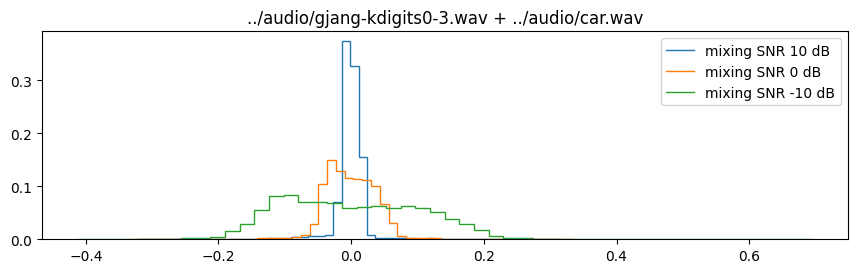

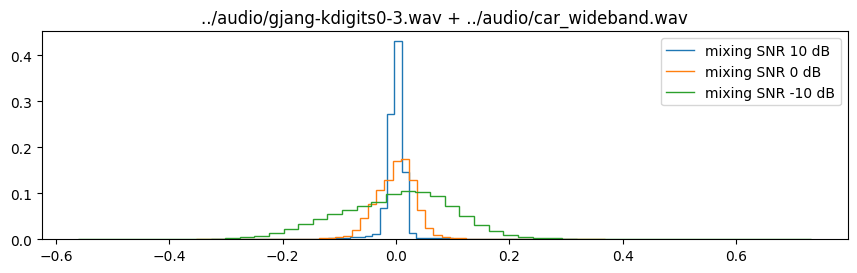

In [16]:
plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
for i in range(1,4):
    plot_relative_hist(mixedSig1[i], bins=50, lab='mixing SNR %.0f dB'%(mixsnrs[i]))
plt.legend(loc='upper right')
plt.title(speechfile + ' + ' + noisefile)

plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
for i in range(1,4):
    plot_relative_hist(mixedSig2[i], bins=50, lab='mixing SNR %.0f dB'%(mixsnrs[i]))
plt.legend(loc='upper right')
plt.title(speechfile + ' + ' + wnoisefile)

- 두 개의 확률 변수의 합으로 이루어진 새로운 확률변수의 확률은 각각의 변수의 확률의 convolution (pdf에서도 성립함)
$$ Z = X + Y \quad \Rightarrow \quad P(Z=z) = \int_{-\infty}^{\infty} P(X=x) P(Y=z-x) dx = \int_{-\infty}^{\infty} P(X=z-y) P(Y=y) dy $$

- 따라서 $f_{Y}(y) = f_{X}(x) \ast f_{N} (n)$ 이 되어서 $n$의 값이 클수록 $f_{X}(x)$ 가 안 보이고 Gaussian 에 수렴한다.

---
### Speech and noise distribution in frame energy domain
- short time energy의 확률 분포를 그려보고 raw signal 분포와 비교한다.
$$ \mathrm{let} \, u[k] = \sqrt{\sum_{t \in \mathrm{frame} \, k} y^2(t)} $$
- draw $p_{X}(u)$ and $p_{N} (u)$

In [17]:
T = len(speech)
num_frames = (T-Nf)//Ns+1
ux, un, uwn = np.zeros(num_frames), np.zeros(num_frames), np.zeros(num_frames)
for k in range(num_frames):
    x = speech[(k*Ns):(k*Ns+Nf)]
    n = noise[(k*Ns):(k*Ns+Nf)]
    wn = wnoise[(k*Ns):(k*Ns+Nf)]
    
    ux[k] = np.sqrt(np.mean(x*x))
    un[k] = np.sqrt(np.mean(n*n))
    uwn[k] = np.sqrt(np.mean(wn*wn))

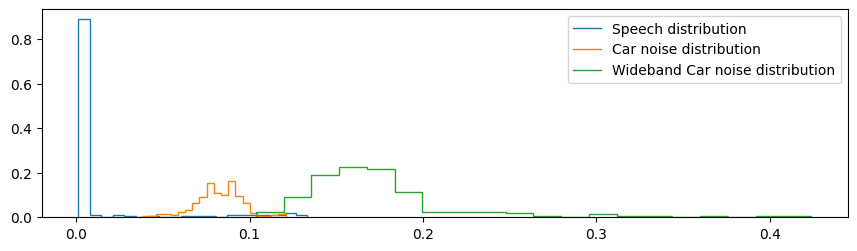

In [18]:
plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
plot_relative_hist(ux, bins=20, lab='Speech distribution')
plot_relative_hist(un, bins=20, lab='Car noise distribution')
plot_relative_hist(uwn, bins=20, lab='Wideband Car noise distribution')
plt.legend(loc='upper right')

- frame energy 로 예측하면 sample distribution 과 매우 다르게 나타난다.
- $u_y[k]$ 를 dual Gaussian mixture model 로 예측한다.

---
### Common classes and methods

공통적으로 사용되는 frame 을 하나씩 추출하는 class를 정의한다.
- `FrameIterator`: for input
- `FrameAccumulator`: for output

__(그림)__

In [19]:
####################################################################
# frame iterator for buffered input
#   returns current frame to process
#   mode = 1: every Ns samples added and returns shifted Nf samples, including last leftover
#   mode = 2: every Ns samples added and returns shifted Nf samples, Not including last leftover
#   mode = 3: every complete Nf samples, number of frames = (T-Nf)//Ns+1
####################################################################
class FrameIterator:
    def __init__(self, T, frame_len, shift_len, mode=1):
        self.set(T, frame_len, shift_len, mode)
        
    def set(self, T, frame_len, shift_len, mode):
        self.Nf = frame_len
        self.Ns = shift_len
        self.frame = np.zeros(self.Nf)
        self.buf = np.zeros(self.Nf-self.Ns)
        self.update_num_frames(mode)
    
    def update_num_frames(self, mode):
        if mode == 1:
            self.num_frames = np.ceil(T/self.Ns).astype(int)   # including last frame (<Ns)
        elif mode == 2:
            self.num_frames = T//self.Ns   # not including last frame (<Ns)
        elif mode == 3:
            self.num_frames = (T-self.Nf)//self.Ns   # only complete frames (speech recognition)
        else:
            print('unknown mode: %d, changed to mode 2'%(mode))
            self.update_num_frames(2)
            
        self.mode = mode
        self.frameIdx = 0    # start from the first frame
        
    def reset(self):  # do not change any sizes, just set zero
        self.frame[:] = 0
        self.buf[:] = 0
    
    #######################################################
    # get one frame from the signal
    # returns frame, actual_frame_len, frame_center_index
    # frame_center_idx may be negative or larger than signal length
    # if Nf > 2*Ns
    def get(self, sig):
        if self.mode == 1 or self.mode == 2:
            t0 = self.frameIdx*self.Ns
            L = min(len(sig)-t0, self.Ns)   # how many samples available from the input
            if L != self.Ns: print('FrameIterator: last leftover %d = %d + %d' % (len(sig),t0,L))
            Noverlap = self.Nf-self.Ns

            if Noverlap > 0:
                self.frame[:Noverlap] = self.buf[:]
                self.frame[Noverlap:(Noverlap+L)] = sig[t0:(t0+L)]
                if L != self.Ns: self.frame[(Noverlap+L):] = 0
                self.buf[:] = self.frame[-(Noverlap):]
            elif Noverlap == 0:   # no buffer necessary
                self.frame[:L] = sig[t0:(t0+L)]
                if L != self.Ns: self.frame[L:] = 0
            else:
                print('wrong noverlap = %d' % (noverlap))
                
            centerIdx = t0-Noverlap+self.Nf//2

        elif mode == 3:
            t0 = self.frameIdx*self.Ns
            L = self.Nf   # complete frames only
            self.frame[:] = sig[t0:(t0+L)]
            centerIdx = t0+self.Nf//2

        # to next frame
        self.frameIdx += 1   # frameIdx is the number of frames returned
        self.Nlast = L   # may be needed later

        return self.frame, L, centerIdx

####################################################################
# frame accumulator for buffered output
#  use nonzero Nprealloc to allocate memory for efficient computation
#  if Nprealloc <= 0, the array is always extended by np.concatenate()
#  which requires memory allocation for every frame accumulation
####################################################################
class FrameAccumulator:
    def __init__(self, Nprealloc = 0):
        self.Tmax = max(Nprealloc,0)   # assert Tmax >= 0
        self.reset()
    def reset(self):
        self.sig = np.zeros(self.Tmax)
        self.sampleIdx = 0
    def buffer(self):
        return self.sig, self.sampleIdx
    
    # method accumulate allows partial copy from x
    # if nonnegative Nx is given, x[:Nx] is accumulated
    # this may be ... more efficient
    def accumulate(self, x, Nx=-1):
        if Nx == -1: Nx = len(x)   # calculate automatically            
        if self.Tmax == 0:
            self.sig = np.concatenate(self.sig, x[:Nx])
        else:
            if self.sampleIdx+Nx<=self.Tmax:
                self.sig[self.sampleIdx:(self.sampleIdx+Nx)] = x[:Nx]
            else:
                print("sample index exceeded, %d + %d = %d > %d"%(self.sampleIdx,Nx,self.sampleIdx+Nx,self.Tmax))

        self.sampleIdx += Nx
        return self.buffer()

frame energy 를 추출하기
- `ShortTImeEngSpectra`: 10ms (변경 가능) frame 들의 energy 와 주파수 스펙트럼 추출 

In [20]:
# function [Esq, CenterSampleIDX] = ShortTimeEng(sig, frame_len, shift_len)
# function [Esq, Ssq, CenterSampleIDX] = ShortTimeEngSpectra(sig, frame_len, shift_len)
#  returns frame energies and spectra of frames shifted by shift_len
#    Esq is |ST(sig)|^2
#    Ssq is |rSTFT(sig)|^2\
#  CenterSampleIDX is the location of the center of the frames (usually for drawing)
#    for sample, frame_len=320, shift_len=160
#    frame1 = [0 320], center1 = [160]
#    frame2 = [160 480], center1 = [320]
#    ...

def ShortTimeEng(sig, frame_len, shift_len):
    it = FrameIterator(len(sig), frame_len, shift_len, mode=1)
    eng = np.zeros(it.num_frames)
    centeridx = np.zeros(it.num_frames, dtype=int)   # center sample indexes
    for k in range(it.num_frames):
        x, _, centeridx[k] = it.get(sig)
        eng[k] = np.mean(x*x)
    return eng, centeridx


def ShortTimeEngSpectra(sig, frame_len, shift_len, fft_len):
    it = FrameIterator(len(sig), frame_len, shift_len, mode=1)
    centeridx = np.zeros(it.num_frames, dtype=int)   # center sample indexes
    eng = np.zeros(it.num_frames)
    spect = np.zeros((it.num_frames,fft_len//2+1))
    for k in range(it.num_frames):
        x, _, centeridx[k] = it.get(sig)
        
        # energy
        eng[k] = np.mean(x*x)
        
        # spectrum
        X = np.fft.fft(x, fft_len)
        hX = X[:(fft_len//2+1)]
        spect[k,:] = (hX*np.conj(hX)).real
        
    return eng, spect, centeridx

SNR 계산하기 

In [21]:
def calcsnr(target, est):
    diff = np.sum((target-est)**2)
    diff = max(diff, 1e-30)   # to prevent divide by zero
    return 10*(np.log10(np.sum(target**2))-np.log10(diff))

Wiener filtering with constant noise spectrum

In [22]:
#####################################################################################
# method WienerFilteringConstantNoise(Ysq, Nest_sq, y, nframe, nshift, noverlap, order, minwfdb=-13)
#   Ysq = |Y(w)|^2, Nest_sq = |N(w)|^2
#   input suggestion: Tf = 20ms, Ts = 10ms, Toverlap = 3ms, order = 1.875ms
#   for 16kHz sampling rate: nframe = 320, nshift = 160, noverlap = 48, order = 30
#   minwfdb: minimum in decibel. -13dB ~ -20 db suggested
#####################################################################################

from gjfiroverlapadd import getLPHFIRFFT
from gjfiroverlapadd import firoverlapadd

def WienerFilteringConstantNoise(Y_a, Nest, y, nframe, nshift, noverlap, order, minwfdb=-13):
    # input validation
    if order % 2 == 1:
        print('only even order is accepted, changing %d --> %d' % (order, order-1))
        order -= 1
    if nframe < nshift:
        print('nframe = %d should be larger than nshift = %d, nframe <-%d' % (nframe, nfhist, nshift))
        nframe = nshift
    if minwfdb >= 0:
        print('minimum Wiener filter gain should > 1.0 (0 dB), %.2e --> %0.f' % (minwfdb, -13))
        minwfdb = -13
    #print(len(y), nframe, nshift, noverlap, order, minwfdb)
        
    minwfgain = 10**(minwfdb/20)    # 0.1
    fola = firoverlapadd()
    fola.set(Ns=nshift, Nov=noverlap, order=order, FIRshift=order//2)
    
    # prepare input iterator and output accumulator
    it = FrameIterator(len(y), nshift, nshift, mode=1)
    centeridx = np.zeros(it.num_frames, dtype=int)   # center sample indexes
    acc = FrameAccumulator(len(y)+fola.getDelay())
    
    H_a = np.zeros_like(Y_a)   # for drawing
    for k in range(Y_a.shape[0]):
        Y = np.maximum(1e-100, np.squeeze(Y_a[k]))   # make a vector and assert non-zero Y
        H = (Y-Nest)/Y
        H = np.maximum(minwfgain, H)   # assert being larger than minimum Wiener filter gain
        H_a[k,:] = H
        
        # time-domain filtering
        h, _ = getLPHFIRFFT(H, order, winname='hamming')
        yk, l, centeridx[k] = it.get(y)
        #print(yk.shape)
        xout, l = fola.doFilterMem(h,yk[:l])
        acc.accumulate(xout, l)
    
    # clearing up last buffer
    while True:
        xout, l = fola.doFilterMem(h,np.zeros(0))
        if l == 0: break
        else: acc.accumulate(xout, l)
        
    return acc, fola.getDelay(), H_a, centeridx

---
### Dual Gaussian mixture model 

Dual scalar Gaussian mixture model with input $x^2$ and zero mean

In [23]:
# definition of log of Gaussian pdf
'''
def normpdf(x, mu, variance):
    #return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sig**2))
    lp = -np.log(sigma)-0.5*(np.log(2*np.pi))-(x-mu)**2/(2*sig**2)
    return np.exp(lp)
'''

def log_normpdf_sq(xsq, variance):
    # mean 0, xsq = x^2, variance = sigma^2
    #returns log( 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sig**2)) )
    return -0.5*(np.log(variance)+np.log(2*np.pi))-xsq/(2*variance)

def normpdf_sq(xsq, variance):
    # mean 0, xsq = x^2, variance = sigma^2
    #returns 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sig**2))
    return np.exp(log_normpdf_sq(xsq, variance))

In [24]:
# mixture of 2 Gaussian pdfs, mean 0
# P(y) = Pr(X) fx(y) / ( Pr(X) fx(y) + Pr(N) fn(y) )
#  fx(y) = 1/(sigma_X sqrt(2 pi)) exp[ -y^2 / (2*sigma_X^2) ]
class dualGMMVAD_time_sq:
    def __init__(self):
        self.var_x = 1.0; self.var_n = 1.0
        self.pr_x = 0.5; self.pr_n = 0.5
        self.dispsetp = 0
        
    def set_dispstep(self,steps=0):
        self.dispstep = steps
    
    ##########################################################################
    def set_initial_params(self, trainYsq):
        # initial parameters
        sorted = np.sort(trainYsq)
        #self.var_n = np.mean(sorted[:(len(sorted)//4*3)])
        #self.var_x = np.mean(sorted[(len(sorted)//4*3):])
        #self.pr_n = 0.75; self.pr_x = 0.25
        self.var_n = np.mean(sorted[:(len(sorted)//2)])
        self.var_x = np.mean(sorted[(len(sorted)//2):])
        self.pr_n = 0.5; self.pr_x = 0.5
        print('Var(X), Pr(X) = %.4f, %.2f  Var(N), Pr(N) = %.4f, %.2f'%(self.var_x, self.pr_x, self.var_n, self.pr_n))
        return None
    
    ##########################################################################
    # training single sample (not implemented yet)
    #def train_one(self):
        
    ##########################################################################
    # training GMM 
    # uselogratio = True,  gamma = 1/(1+Pn/Px exp(log(fx)-log(fn))
    #              False,  gamma = Px fx / ( Px fx + Pn fn )
    def train_batch(self, trainYsq, epoch=10, uselogratio=False):
        # for better scaling in display
        maxY = np.max(trainYsq)
        
        for ii in range(1,epoch+1):
            # expectation
            # compute pdf f(y|sigma^2)
            lfx = log_normpdf_sq(trainYsq, self.var_x)
            lfn = log_normpdf_sq(trainYsq, self.var_n)
            
            if uselogratio == True:
                gamma = 1/(1+self.pr_n/self.pr_x*np.exp(lfn-lfx))
            else:
                fx = np.exp(lfx); fn = np.exp(lfn)
                gamma = self.pr_x*fx/(self.pr_x*fx+self.pr_n*fn)
            
            # debugging
            if self.dispstep > 0:
                if ii % self.dispstep == 0 or ii == epoch or ii == 1:
                    plt.plot(gamma, label=('p(voice|y)@%d pr%.2f var%.2e'%(ii,self.pr_x,self.var_x)))
                    plt.xlim(0,len(gamma))
                    plt.ylim(-0.1,1.1)
                    Vx_scaled = self.var_x/maxY            
                    Vn_scaled = self.var_n/maxY
                    print('Epoch %d: Var(X),Var(N) = (%.3f, %.3f)x%.3e  Pr(X),Pr(N) = (%.2f, %.2f)'%(ii, Vx_scaled, Vn_scaled, maxY, self.pr_x, self.pr_n))

            # maximization (parameter update)
            self.pr_x = np.sum(gamma)/len(gamma)
            self.pr_n = 1-self.pr_x
            self.var_x = sum(gamma*trainYsq)/sum(gamma)
            self.var_n = sum((1-gamma)*trainYsq)/sum(1-gamma)
            
            # assert var_n <= var_x
            if self.var_x < self.var_n:
                print("WARNING: Vx < Vn (%.2e < %.2e), swapping parameters"%(self.var_x, self.var_n))
                tmp = self.pr_x
                self.pr_x = self.pr_n
                self.pr_n = tmp
                tmp = self.var_x
                self.var_x = self.var_n
                self.var_n = tmp
                
        # returns posterior probability
        if epoch > 0: return gamma
        else: return None

---
### VAD and Wiener filtering actual run
- single experiment, GMM learning 과정을 그림으로 그리고, Energy, 최종 VAD, 입력신호를 비교하여 그림
- noise suppression results 와 true speech 와 SNR 비교
- 발생되는 delay (order//2 + overlap) 는 없애준다.
- 파일 저장

In [25]:
def doexp_vad_time(y, snr, epoch=9, dispstep=3, uselogratio=True, xtarget=[], fname_header='ns'):
    gmm = dualGMMVAD_time_sq()
    gmm.set_dispstep(dispstep)

    #u, Iu = ShortTimeFrameEng(y, Nf, Ns)
    usq, Ysq, Iu = ShortTimeEngSpectra(y, Nf, Ns, NFFT)

    # drawing start to visualize training
    nplots = 4; pos = 0
    plt.figure(figsize=FIG_SIZE*np.array([1.3,2.0]))
    pos+=1; plt.subplot(nplots,1,pos)

    # train dual GMM
    gmm.set_initial_params(usq)
    gamma = gmm.train_batch(usq, epoch, uselogratio)

    # find noise estimates and apply Wiener filtering
    Ne_sq = np.dot(1-gamma,Ysq)/np.sum(1-gamma)
    xacc, xdelay, H_a, centerIdx = WienerFilteringConstantNoise(Ysq, Ne_sq, y, Nf, Ns, noverlap=Fs//1000*3, order=30, minwfdb=-13)

    # save the noise suppressed audio file
    fname = addpath(outpath, '%s%.fdb.wav' % (fname_header,snr))
    xest, Nx = xacc.buffer()
    #xest = xest[(len(xest)-len(y)):Nx]   # remove the delay
    xest = xest[xdelay:Nx]   # roll back the delay
    wav.writewav(fname, Fs, xest, maxval=1.0)

    # drawing
    plt.subplot(nplots,1,pos)
    plt.legend(loc='upper right')
    if len(xtarget) == 0:
        plt.title('SNR = %.0fdB'%(snr))
    else:
        snrmix = calcsnr(xtarget, y)
        snrest = calcsnr(xtarget, xest)
        plt.title('Time-Eng GMM, SNR = %.2f -> %.2f dB' % (snrmix, snrest))
    
    # draw VAD results
    pos+=1; plt.subplot(nplots,1,pos)
    plt.plot(np.arange(1,len(y)+1)/Fs,y,label='y@%.0fdB'%(snr))
    plt.plot(Iu/Fs,gamma,label='gamma[k] = P(voice|y)')
    plt.plot(Iu/Fs,usq/max(usq)*max(np.abs(y))*1.5,label='u^2[k] = Eng_y')
    plt.xlim(0,len(y)/Fs)
    plt.legend(loc='upper right')
    
    '''
    plt.subplot(nplots,1,pos); pos+=1
    print(gamma.shape)
    print(Y.shape)
    Ymean = np.sum(Y,axis=0)/Y.shape[0]
    Xmean = np.dot(gamma,Y)/np.sum(gamma)
    Ne = np.dot(1-gamma,Y)/np.sum(1-gamma)
    plt.plot(Ymean, label='Y')
    plt.plot(Xmean, label='X')
    plt.plot(Ne, label='Nest')
    plt.legend(loc='upper right')
    print(Y.shape[0], np.sum(gamma))
    '''
    
    pos+=1; plt.subplot(nplots,1,pos)
    plt.imshow(H_a.T, cmap=cmap_plot, aspect='auto', origin='lower')
    plt.text(0,H_a.shape[1]/2,'Wiener Filter Gain',color='red')
    
    plt.subplot(nplots,2,pos*2+1)
    plt.plot(np.arange(1,len(y)+1)/Fs,xest,label='estimated x')
    plt.plot(Iu/Fs,gamma,label='g_k = P(voice|y)')
    plt.xlim(0,len(y)/Fs)
    plt.legend(loc='upper left')
    plt.subplot(nplots,2,pos*2+2)
    drawspectrogram3(xest, Fs, Nf, Ns, minpercentile=50, isdbscale=True, isdraw=True)
    pos+=1    
        
    return xest, fname

- 여러 가지 값의 SNR 로 mixing 된 입력으로 VAD + NS 수행

FrameIterator: last leftover 37952 = 37920 + 32
Var(X), Pr(X) = 0.0020, 0.50  Var(N), Pr(N) = 0.0000, 0.50
Epoch 1: Var(X),Var(N) = (0.113, 0.001)x1.782e-02  Pr(X),Pr(N) = (0.50, 0.50)
Epoch 3: Var(X),Var(N) = (0.407, 0.001)x1.782e-02  Pr(X),Pr(N) = (0.14, 0.86)
Epoch 6: Var(X),Var(N) = (0.502, 0.001)x1.782e-02  Pr(X),Pr(N) = (0.11, 0.89)
Epoch 9: Var(X),Var(N) = (0.502, 0.001)x1.782e-02  Pr(X),Pr(N) = (0.11, 0.89)
FrameIterator: last leftover 37952 = 37920 + 32
FrameIterator: last leftover 37952 = 37920 + 32
Var(X), Pr(X) = 0.0021, 0.50  Var(N), Pr(N) = 0.0001, 0.50
Epoch 1: Var(X),Var(N) = (0.118, 0.005)x1.795e-02  Pr(X),Pr(N) = (0.50, 0.50)
Epoch 3: Var(X),Var(N) = (0.256, 0.006)x1.795e-02  Pr(X),Pr(N) = (0.22, 0.78)
Epoch 6: Var(X),Var(N) = (0.482, 0.006)x1.795e-02  Pr(X),Pr(N) = (0.12, 0.88)
Epoch 9: Var(X),Var(N) = (0.501, 0.006)x1.795e-02  Pr(X),Pr(N) = (0.11, 0.89)
FrameIterator: last leftover 37952 = 37920 + 32
FrameIterator: last leftover 37952 = 37920 + 32
Var(X), Pr(X) = 0.

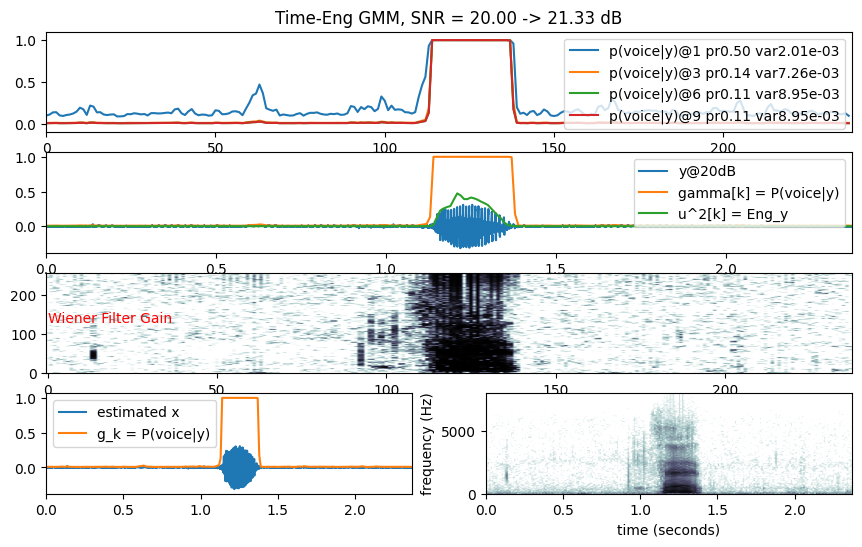

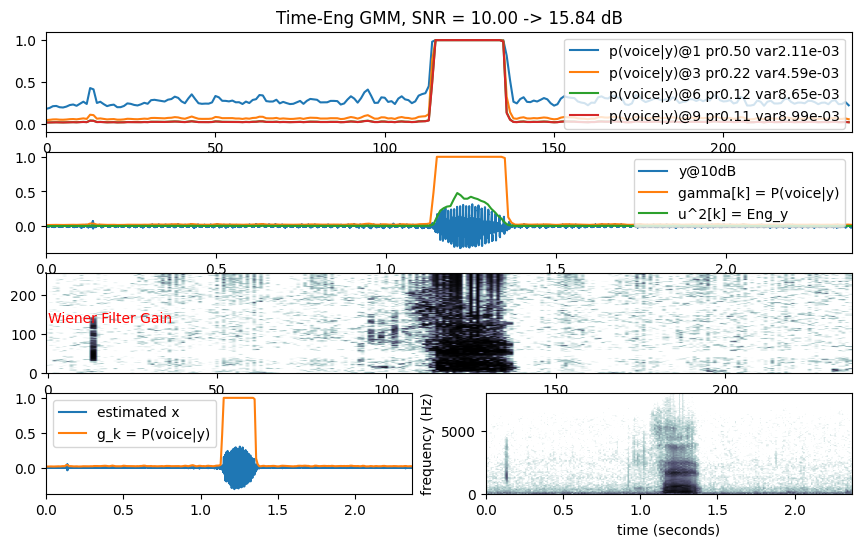

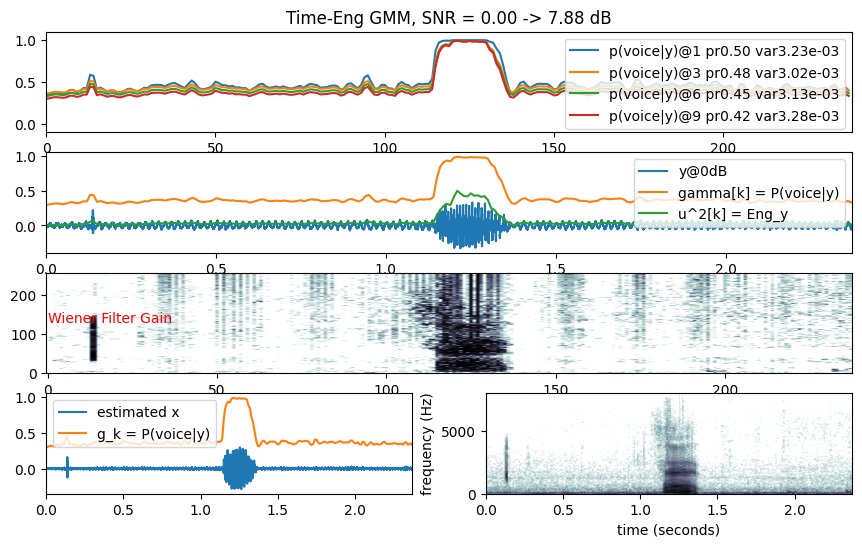

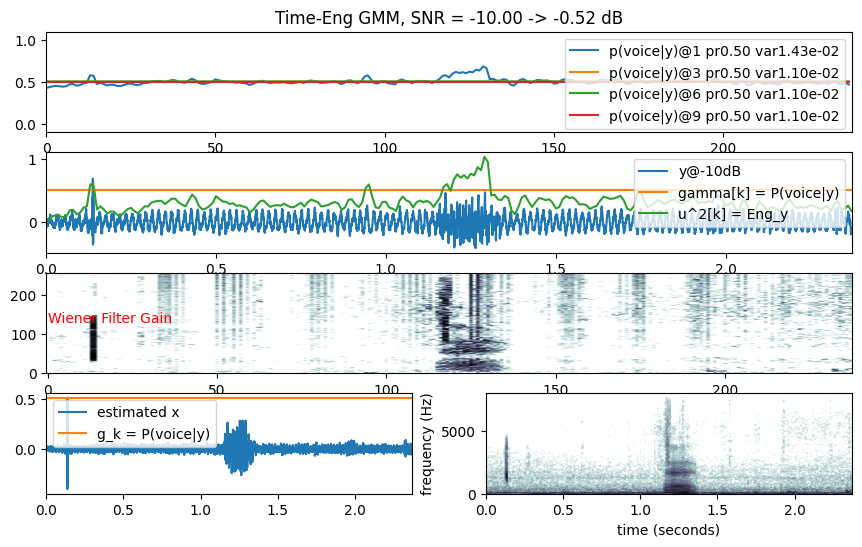

In [26]:
nsWavfiles = []
nsSig = []
for ii in range(len(mixedSig1)):
    xe, fname = doexp_vad_time(mixedSig1[ii], mixsnrs[ii], 9, 3, xtarget=speech, fname_header='nbn_timegmm')
    nsWavfiles.append(fname)
    nsSig.append(xe)

1. __20dB__: 거의 완벽한 VAD. Noise spectrum 이 워낙 작아 차감이 거의 없어 SNR 변화가 적다. 
1. __10dB__: 거의 완벽한 VAD. 6 dB (1/2 suppression) 정도의 감쇠 효과
1. __0dB__: GMM-VAD는 거의 학습되지 않고 초기값 유지. 그래도 energy 의 차이가 있어서 VAD 어느 정도 되고 SNR 이득 7.88 dB
1. __-10dB__: GMM-VAD learning failure. 0.5 에 수렴(구분이 전혀 안됨). Noise는 전체 구간의 평규으로 추청된 것이며, noise 가 많이 분표되어 있어 어느정도 유사하게 추정되어 9.5 dB 이득 있음. 하지만 speech 왜곡 발생.

들어보자.

In [27]:
fname = nsWavfiles[0]
print(fname)
IPython.display.Audio(fname)

out/nbn_timegmm20db.wav


In [28]:
fname = nsWavfiles[1]
print(fname)
IPython.display.Audio(fname)

out/nbn_timegmm10db.wav


In [29]:
fname = nsWavfiles[2]
print(fname)
IPython.display.Audio(fname)

out/nbn_timegmm0db.wav


In [30]:
fname = nsWavfiles[3]
print(fname)
IPython.display.Audio(fname)

out/nbn_timegmm-10db.wav


Wideband noise 실험

FrameIterator: last leftover 37952 = 37920 + 32
Var(X), Pr(X) = 0.0020, 0.50  Var(N), Pr(N) = 0.0000, 0.50
Epoch 1: Var(X),Var(N) = (0.113, 0.001)x1.773e-02  Pr(X),Pr(N) = (0.50, 0.50)
Epoch 3: Var(X),Var(N) = (0.399, 0.001)x1.773e-02  Pr(X),Pr(N) = (0.14, 0.86)
Epoch 6: Var(X),Var(N) = (0.497, 0.001)x1.773e-02  Pr(X),Pr(N) = (0.11, 0.89)
Epoch 9: Var(X),Var(N) = (0.497, 0.001)x1.773e-02  Pr(X),Pr(N) = (0.11, 0.89)
FrameIterator: last leftover 37952 = 37920 + 32
FrameIterator: last leftover 37952 = 37920 + 32
Var(X), Pr(X) = 0.0021, 0.50  Var(N), Pr(N) = 0.0001, 0.50
Epoch 1: Var(X),Var(N) = (0.121, 0.004)x1.766e-02  Pr(X),Pr(N) = (0.50, 0.50)
Epoch 3: Var(X),Var(N) = (0.248, 0.006)x1.766e-02  Pr(X),Pr(N) = (0.23, 0.77)
Epoch 6: Var(X),Var(N) = (0.471, 0.007)x1.766e-02  Pr(X),Pr(N) = (0.12, 0.88)
Epoch 9: Var(X),Var(N) = (0.499, 0.007)x1.766e-02  Pr(X),Pr(N) = (0.11, 0.89)
FrameIterator: last leftover 37952 = 37920 + 32
FrameIterator: last leftover 37952 = 37920 + 32
Var(X), Pr(X) = 0.

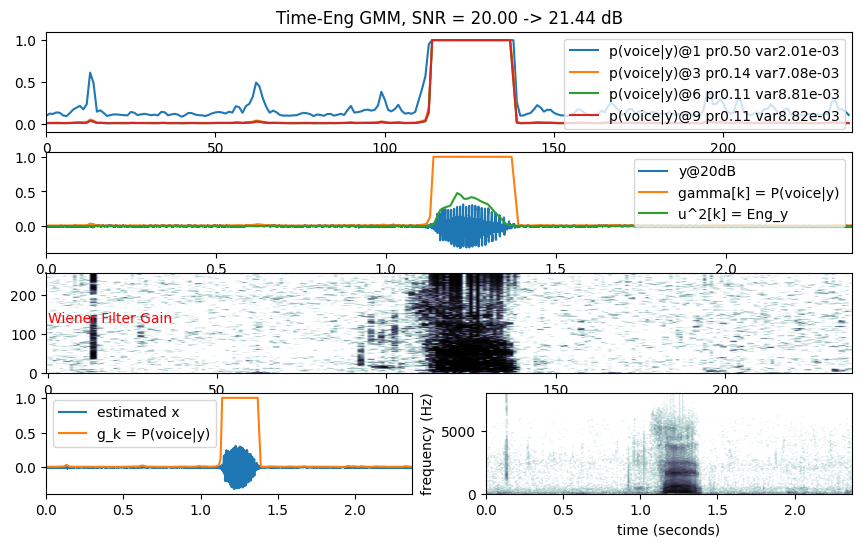

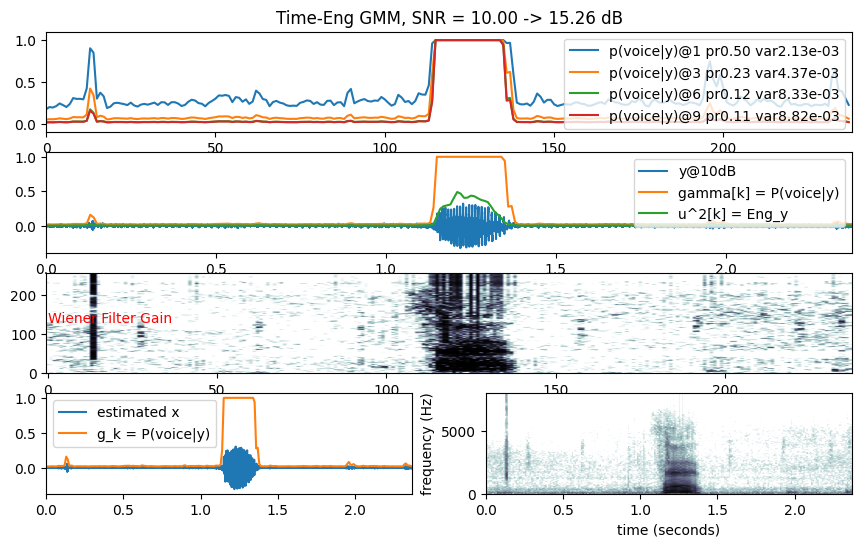

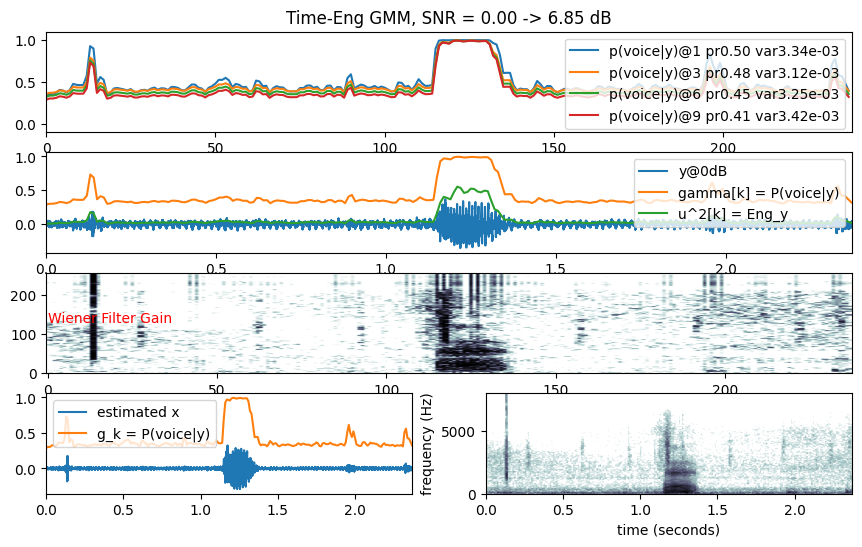

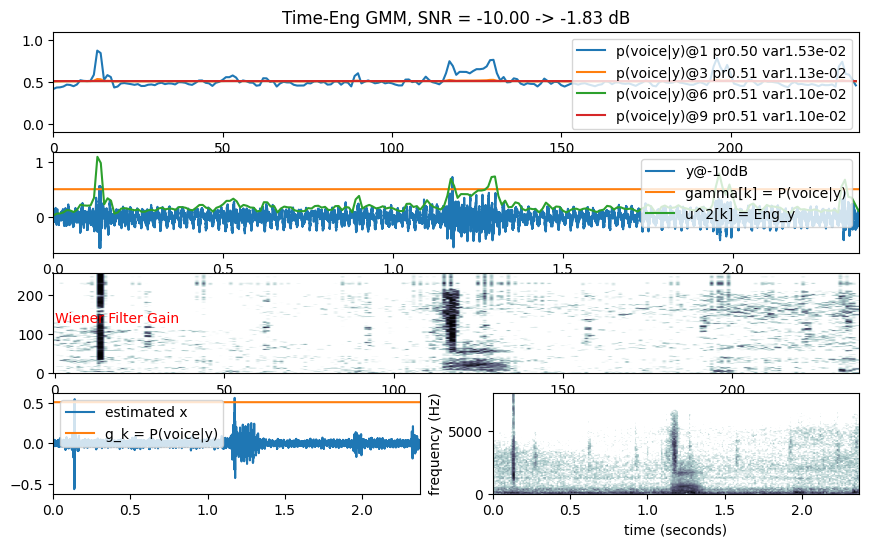

In [31]:
nsWavfiles = []
nsSig = []
for ii in range(len(mixedSig2)):
    xe, fname = doexp_vad_time(mixedSig2[ii], mixsnrs[ii], 9, 3, xtarget=speech, fname_header='wbn_timegmm')
    nsWavfiles.append(fname)
    nsSig.append(xe)

이어폰으로 들어봐야 narrowband와 차이를 알 수 있다. 

Stationary 하지 않은 깜박이 소리는 거의 제거되지 않는다.

In [32]:
fname = nsWavfiles[0]
print(fname)
IPython.display.Audio(fname)

out/wbn_timegmm20db.wav


In [33]:
fname = nsWavfiles[1]
print(fname)
IPython.display.Audio(fname)

out/wbn_timegmm10db.wav


In [34]:
fname = nsWavfiles[2]
print(fname)
IPython.display.Audio(fname)

out/wbn_timegmm0db.wav


In [35]:
fname = nsWavfiles[3]
print(fname)
IPython.display.Audio(fname)

out/wbn_timegmm-10db.wav


.

---
## 3. frequency domain VAD using dual, multivariate Rayleigh mixture model 

1. Fourier transform on $y(t) \rightarrow Y(\omega)$
2. $|X(\omega)|^2$, $|N(\omega)|^2$ 의 분포를 Rayleigh distribution 으로 가정하고 $|Y(\omega)|^2$ 의 분포를 dual mixture model 로 학습
3. 작은 크기의 Rayleigh distribution 의 $\sigma^2$ parameter 로 $|\tilde{N}(\omega)|^2$ 추정

### Rayleigh distribution
- Random variable $R = A + j B$, $A \sim N(0, \sigma^2$, $B \sim N(0, \sigma^2$, $E[AB] = 0$ 을 만들어서 $|R|$ 이 Rayleigh 분포를 확인한다.
$$ f_X (x|\sigma) = \frac{x}{\sigma^2} \exp\left( -\frac{x^2}{2 \sigma^2} \right) $$
$$ \tilde{\sigma}^2 = \frac{1}{2N} \sum_{i=1}^{N} x_{i}^2 $$

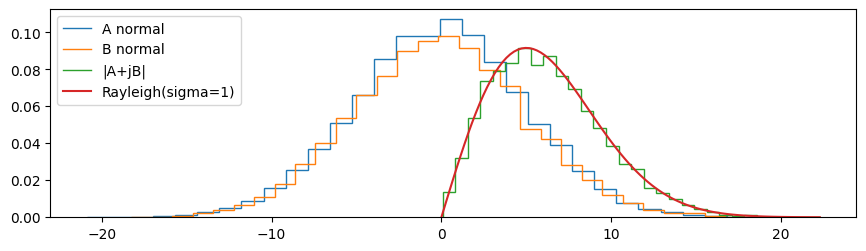

In [36]:
A = np.random.normal(0,5,10000)
B = np.random.normal(0,5,10000)
R = A + 1j*B
aR = np.sqrt((R*np.conj(R)).real)
x = np.linspace(0,max(aR),num=100)
sigma = 5
fx = x/sigma**2 *np.exp(-x**2/(2*sigma**2))
plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
plot_relative_hist(A, bins=30, lab='A normal')
plot_relative_hist(B, bins=30, lab='B normal')
bins=plot_relative_hist(aR, bins=30, lab='|A+jB|')
plt.plot(x, fx/max(fx)*max(bins), label='Rayleigh(sigma=1)')
plt.legend(loc='upper left')

---
### Multivariate dual Rayleigh mixture model 

- 각 주파수 성분 $|Y(\omega)|$를 Rayleigh mixture, 그리고 이를 곱한 pdf 로 multivariate pdf 추정

In [37]:
'''
def log_multi_rayleigh(x, sigmasq):
    # x and siqmasq same shape
    #return np.log(x)-2*np.log(sigma)-((x/sigma)**2)/2
    return np.sum( np.log(x)-np.log(sigmasq)-(x*x/sigmasq)/2 )

def multi_rayleigh(x, sigmasq):
    return np.exp(log_multi_rayleigh(x, sigmasq))
'''
# definition of log of Rayleigh pdf
# x and sigmasq are scalar
def log_rayleigh(x, sigmasq):
    #return np.log(x)-2*np.log(sigma)-((x/sigma)**2)/2
    return np.log(x)-np.log(sigmasq)-(x*x/sigmasq)/2

def log_multi_rayleigh(X, sigmasq):
    # X: N x D
    # sigmasq: D
    # using broadcasting, NxD + D -> NxD
    #print('log_multi_rayleigh:', X.shape, sigmasq.shape)
    return np.sum( np.log(X)-np.log(sigmasq)-((X*X)/sigmasq)/2, axis=1 )

In [38]:
# mixture of 2 Gaussian pdfs, mean 0
# P(y) = Pr(X) fx(y) / ( Pr(X) fx(y) + Pr(N) fn(y) )
#  fx(y) = y/(sigma_X^2) exp[ -y^2 / (2*sigma_X^2) ]
#  fn(y) = y/(sigma_N^2) exp[ -y^2 / (2*sigma_N^2) ]
class dualRayleighVAD_freq:
    def __init__(self):
        self.sigmasq_X = 1.0; self.sigmasq_N = 1.0
        self.pr_X = 0.5; self.pr_N = 0.5
        self.dispsetp = 0
        
    def set_dispstep(self,steps=0):
        self.dispstep = steps
        
    def print_parameters(self):
        #print('Ssq(N), Pr(N) = %.4f, %.2f  Ssq(X), Pr(X) = %.4f, %.2f'%(self.sigmasq_n, self.pr_n, self.sigmasq_x, self.pr_x))
        print('Pr(X), Pr(N) = %.4f, %.4f'%(self.pr_X, self.pr_N))
        print('Ssq(X):')
        print(self.sigmasq_X.shape, np.mean(self.sigmasq_X))
        print('Ssq(N):')
        print(self.sigmasq_N.shape, np.mean(self.sigmasq_N))
    
    ##########################################################################
    def set_initial_params(self, trainY):
        # initial parameters
        #sorted = np.sort(trainYsq)
        #hN = len(sorted)//2
        #self.sigmasq_N = np.mean(sorted[:hN,:]**2,axis=0)/2
        #self.sigmasq_X = np.mean(sorted[hN:,:]**2,axis=0)/2
        #self.pr_N = 0.5; self.pr_X = 0.5
        Ysq = trainY**2
        mYsq = np.mean(Ysq, axis=1)  # 각 시간별 주파수 성분들의 평균
        mmYsq = np.mean(mYsq)  # 모든 성분들의 평균
        print('trainY^2 and mYsq: ', Ysq.shape, mYsq.shape, mmYsq)
        self.sigmasq_X = np.mean(trainY[mYsq>=mmYsq,:]**2,axis=0)/2
        self.sigmasq_N = np.mean(trainY[mYsq<mmYsq,:]**2,axis=0)/2
        self.pr_X = np.sum(mYsq>=mmYsq)/len(mYsq)
        self.pr_N = 1-self.pr_X
        self.print_parameters()
        return None
    
    ##########################################################################
    # training single sample (not implemented yet)
    #def train_one(self):
        
    ##########################################################################
    # training GMM 
    #  trainY: num_frames x num_freq_bins
    #  epoch: how many iterations
    #  uselogratio = True,  gamma = 1/(1+Pn/Px exp(log(fx)-log(fn))
    #              False,  gamma = Px fx / ( Px fx + Pn fn )
    def train_batch(self, trainY, epoch=10, uselogratio=True):
        # for better scaling in display
        maxY = np.max(trainY)
        
        gamma = np.zeros(trainY.shape[0])        
        for ii in range(1,epoch+1):
            # expectation
            # compute pdf f(y|sigma^2)
            lfX = log_multi_rayleigh(trainY, self.sigmasq_X)
            lfN = log_multi_rayleigh(trainY, self.sigmasq_N)
            
            if uselogratio == True:
                #gamma = 1/(1+self.pr_N/self.pr_X*np.exp(lfN-lfX))
                # multivariate sum 을 하면 lfN-lfX 가 너무 작아지는 경우가 있다. 
                # exp(-100) = 3.72e-44 -> -100보다 작으면 exp(.)를 0으로
                # exp(100) = 2.67e+43 -> 100보다 크면 exp(.)를 무한대로
                # 해 보면 거의 0 이나 1 이 된다. 그래서 아래처럼 하는 것이 계산상 효율적임.
                ldiff = lfN-lfX
                Il = ldiff<=-100; Ih = ldiff>=100                
                Im = np.logical_and(Il==False, Ih==False)
                print('gamma 1/~/0 counts = (%d, %d, %d)' % (sum(Il), sum(Im), sum(Ih)))
                gamma[Il] = 1
                gamma[Ih] = 0
                gamma[Im] = 1/(1+self.pr_N/self.pr_X*np.exp(ldiff[Im]))
            else:
                fX = np.exp(lfX); fN = np.exp(lfN)
                gamma[:] = self.pr_X*fX/(self.pr_X*fX+self.pr_N*fN)
            
            # debugging
            if self.dispstep > 0:
                if ii % self.dispstep == 0 or ii == epoch or ii == 1:
                    plt.plot(gamma, label=('p(v|y)@%d pr%.2f |sig^2|%.2e'%(ii,self.pr_X,np.mean(self.sigmasq_X))))
                    plt.xlim(0,len(gamma))
                    plt.ylim(-0.1,1.1)
                    SsqX_scaled = np.mean(self.sigmasq_X)/maxY            
                    SsqN_scaled = np.mean(self.sigmasq_N)/maxY
                    print('Epoch %d: sigma^2(X),sigma^2(N) = (%.3f, %.3f)x%.3e  Pr(X),Pr(N) = (%.2f, %.2f)'%(ii, SsqX_scaled, SsqN_scaled, maxY, self.pr_X, self.pr_N))

            # maximization (parameter update)
            self.pr_X = np.sum(gamma)/len(gamma)
            self.pr_N = 1-self.pr_X
            Ysq = (trainY**2)
            #self.sigmasq_X = sum(Ysq.T*gamma)/(2*sum(gamma))
            #self.sigmasq_N = sum(Ysq.T*(1-gamma))/(2*sum(1-gamma))
            print(gamma.shape)
            self.sigmasq_X = np.dot(gamma,Ysq)/(2*sum(gamma))
            self.sigmasq_N = np.dot(1-gamma, Ysq)/(2*sum(1-gamma))
            
            '''
            # not sure how with Rayleigh
            # assert var_n <= var_x
            if self.var_x < self.var_n:
                print("WARNING: Vx < Vn (%.2e < %.2e), swapping parameters"%(self.var_x, self.var_n))
                tmp = self.pr_x
                self.pr_x = self.pr_n
                self.pr_n = tmp
                tmp = self.var_x
                self.var_x = self.var_n
                self.var_n = tmp
            '''

        # returns posterior probability
        if epoch > 0: return gamma
        else: return None

---
### VAD and Wiener filtering actual run
- function for single experiment, Rayleigh mixture model learning 과정을 그림으로 그리고, 최종 VAD 와 입력신호를 비교하여 그림
- noise suppression results 와 true speech 와 SNR 비교. 발생되는 delay (order//2 + overlap) 는 없애준다.
- 결과 파일 저장 및 들어보기 

In [39]:
def doexp_vad_rayleigh(y, snr, epoch=9, dispstep=3, uselogratio=True, xtarget=[], fname_header='ns'):
    rmm = dualRayleighVAD_freq()
    rmm.set_dispstep(dispstep)

    _, Ysq, Iu = ShortTimeEngSpectra(y, Nf, Ns, NFFT)
    aY = np.sqrt(Ysq)

    # drawing start to visualize training
    nplots = 4; pos = 0
    plt.figure(figsize=FIG_SIZE*np.array([1.3,2.0]))
    pos+=1; plt.subplot(nplots,1,pos)

    # train dual GMM
    rmm.set_initial_params(aY)
    gamma = rmm.train_batch(aY, epoch, uselogratio)

    # find noise estimates and apply Wiener filtering
    #Ne_sq = np.dot(1-gamma,Ysq)/np.sum(1-gamma)
    Ne_sq = rmm.sigmasq_N
    xacc, xdelay, H_a, centerIdx = WienerFilteringConstantNoise(Ysq, Ne_sq, y, Nf, Ns, noverlap=Fs//1000*3, order=30, minwfdb=-20)
    
    # save the noise suppressed audio file
    fname = addpath(outpath, '%s%.fdb.wav' % (fname_header,snr))
    xest, Nx = xacc.buffer()
    #xest = xest[(len(xest)-len(y)):Nx]   # remove the delay
    xest = xest[xdelay:Nx]   # roll back the delay
    wav.writewav(fname, Fs, xest, maxval=1.0)

    # drawing
    plt.subplot(nplots,1,pos)
    plt.legend(loc='upper left')
    if len(xtarget) == 0:
        plt.title('SNR = %.0fdB'%(snr))
    else:
        snrmix = calcsnr(xtarget, y)
        snrest = calcsnr(xtarget, xest)
        plt.title('Freq Rayleigh MM, SNR = %.2f -> %.2f dB' % (snrmix, snrest))
    
    # draw VAD results
    pos+=1; plt.subplot(nplots,1,pos)
    plt.plot(np.arange(1,len(y)+1)/Fs,y,label='y@%.0fdB'%(snr))
    plt.plot(Iu/Fs,gamma,label='gamma[k] = P(voice|y)')
    Ysq_mean = np.mean(Ysq,axis=1)
    plt.plot(Iu/Fs,Ysq_mean/max(Ysq_mean)*max(np.abs(y))*1.5,label='mean(Y^2[k,:])')
    plt.xlim(0,len(y)/Fs)
    plt.legend(loc='upper right')
    
    pos+=1; plt.subplot(nplots,1,pos)
    plt.imshow(H_a.T, cmap=cmap_plot, aspect='auto', origin='lower')
    plt.text(0,H_a.shape[1]/2,'Wiener Filter Gain',color='red')
    
    plt.subplot(nplots,2,pos*2+1)
    plt.plot(np.arange(1,len(y)+1)/Fs,xest,label='estimated x')
    plt.plot(Iu/Fs,gamma,label='g_k = P(voice|y)')
    plt.xlim(0,len(y)/Fs)
    plt.legend(loc='upper left')
    plt.subplot(nplots,2,pos*2+2)
    drawspectrogram3(xest, Fs, Nf, Ns, minpercentile=50, isdbscale=True, isdraw=True)
    pos+=1    
        
    return xest, fname

- 여러 가지 값의 SNR 로 mixing 된 입력으로 VAD + NS 수행

FrameIterator: last leftover 37952 = 37920 + 32
trainY^2 and mYsq:  (238, 257) (238,) 0.32329000812199127
Pr(X), Pr(N) = 0.0882, 0.9118
Ssq(X):
(257,) 1.7806826923112022
Ssq(N):
(257,) 0.00496393745613692
gamma 1/~/0 counts = (27, 0, 211)
Epoch 1: sigma^2(X),sigma^2(N) = (0.110, 0.000)x1.617e+01  Pr(X),Pr(N) = (0.09, 0.91)
(238,)
gamma 1/~/0 counts = (28, 0, 210)
(238,)
gamma 1/~/0 counts = (28, 1, 209)
Epoch 3: sigma^2(X),sigma^2(N) = (0.083, 0.000)x1.617e+01  Pr(X),Pr(N) = (0.12, 0.88)
(238,)
gamma 1/~/0 counts = (28, 1, 209)
(238,)
gamma 1/~/0 counts = (28, 1, 209)
(238,)
gamma 1/~/0 counts = (28, 1, 209)
Epoch 6: sigma^2(X),sigma^2(N) = (0.083, 0.000)x1.617e+01  Pr(X),Pr(N) = (0.12, 0.88)
(238,)
gamma 1/~/0 counts = (28, 1, 209)
(238,)
gamma 1/~/0 counts = (28, 1, 209)
(238,)
gamma 1/~/0 counts = (28, 1, 209)
Epoch 9: sigma^2(X),sigma^2(N) = (0.083, 0.000)x1.617e+01  Pr(X),Pr(N) = (0.12, 0.88)
(238,)
FrameIterator: last leftover 37952 = 37920 + 32
FrameIterator: last leftover 37952

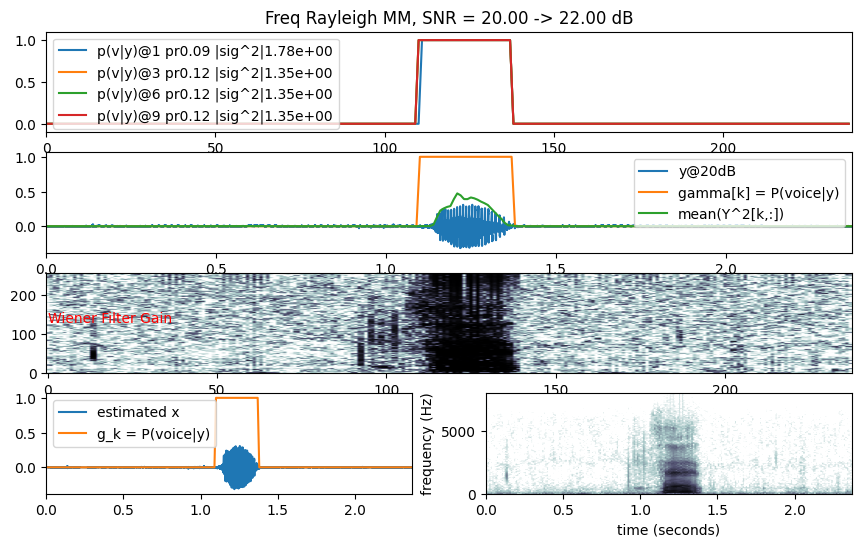

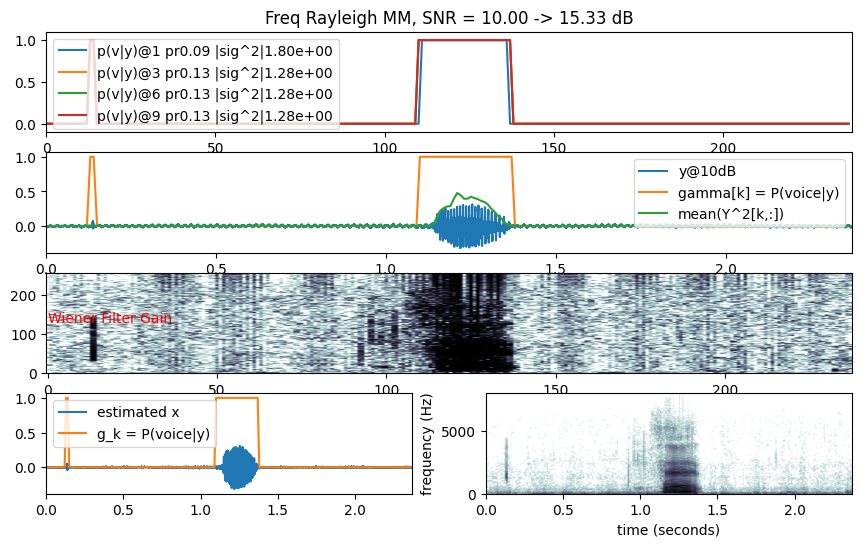

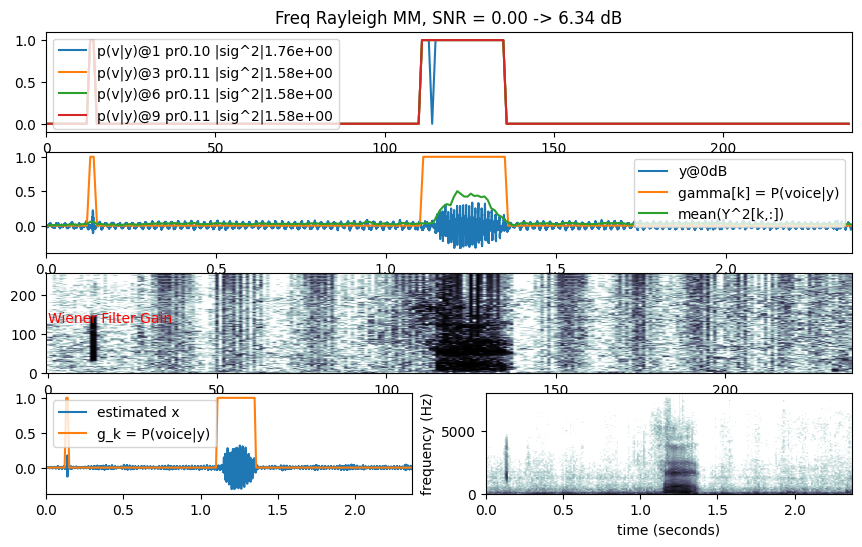

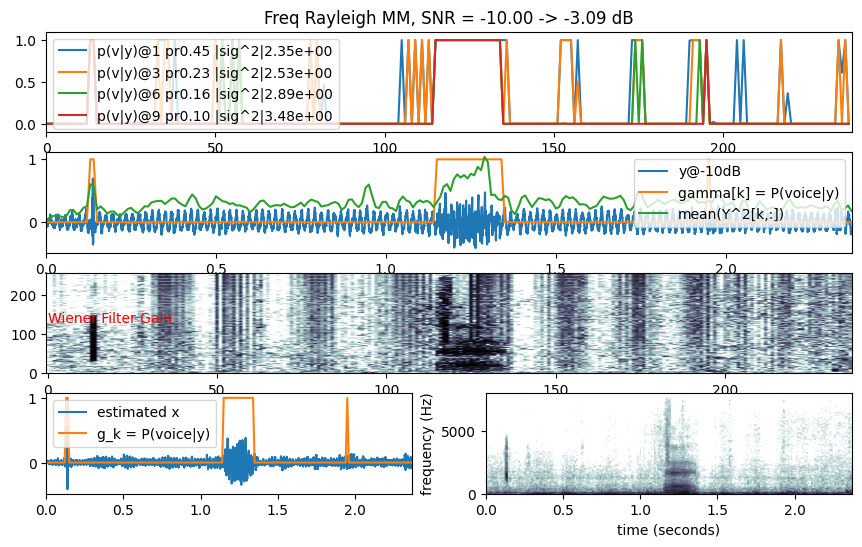

In [40]:
nsWavfiles = []
nsSig = []
for ii in range(len(mixedSig1)):
    xe, fname = doexp_vad_rayleigh(mixedSig1[ii], mixsnrs[ii], 9, 3, xtarget=speech, fname_header='nbn_rayleigh')
    nsWavfiles.append(fname)
    nsSig.append(xe)

1. time energy GMM 보다 훨씬 VAD 성능이 좋아짐
1. __0dB__, __-10dB__: VAD 가 거의 perfect
1. 아쉽게도 noise suppression SNR 성능은 minimum Wiener filter gain 을 -20 dB로 해도 크게 좋아지진 않는다. 
1. listening quality 마찬가지. 오히려 꿀렁거리는 소리가 들림
    > noise 가 non-stationary 한 경우 주로 발생. Oversubtraction (H = (Y- alpha N)/Y, alpha>1) 로 어느정도 해결할 수 있지만 speech 의 왜곡이 발생할 수 있다.

들어보자.

In [41]:
fname = nsWavfiles[0]; print(fname)
IPython.display.Audio(fname)

out/nbn_rayleigh20db.wav


In [42]:
fname = nsWavfiles[1]; print(fname)
IPython.display.Audio(fname)

out/nbn_rayleigh10db.wav


In [43]:
fname = nsWavfiles[2]; print(fname)
IPython.display.Audio(fname)

out/nbn_rayleigh0db.wav


In [44]:
fname = nsWavfiles[3]; print(fname)
IPython.display.Audio(fname)

out/nbn_rayleigh-10db.wav


Wideband noise 실험

FrameIterator: last leftover 37952 = 37920 + 32
trainY^2 and mYsq:  (238, 257) (238,) 0.32371466292411977
Pr(X), Pr(N) = 0.0882, 0.9118
Ssq(X):
(257,) 1.7810660885431784
Ssq(N):
(257,) 0.005159709809048422
gamma 1/~/0 counts = (29, 0, 209)
Epoch 1: sigma^2(X),sigma^2(N) = (0.110, 0.000)x1.624e+01  Pr(X),Pr(N) = (0.09, 0.91)
(238,)
gamma 1/~/0 counts = (30, 0, 208)
(238,)
gamma 1/~/0 counts = (30, 0, 208)
Epoch 3: sigma^2(X),sigma^2(N) = (0.078, 0.000)x1.624e+01  Pr(X),Pr(N) = (0.13, 0.87)
(238,)
gamma 1/~/0 counts = (30, 0, 208)
(238,)
gamma 1/~/0 counts = (30, 0, 208)
(238,)
gamma 1/~/0 counts = (30, 0, 208)
Epoch 6: sigma^2(X),sigma^2(N) = (0.078, 0.000)x1.624e+01  Pr(X),Pr(N) = (0.13, 0.87)
(238,)
gamma 1/~/0 counts = (30, 0, 208)
(238,)
gamma 1/~/0 counts = (30, 0, 208)
(238,)
gamma 1/~/0 counts = (30, 0, 208)
Epoch 9: sigma^2(X),sigma^2(N) = (0.078, 0.000)x1.624e+01  Pr(X),Pr(N) = (0.13, 0.87)
(238,)
FrameIterator: last leftover 37952 = 37920 + 32
FrameIterator: last leftover 3795

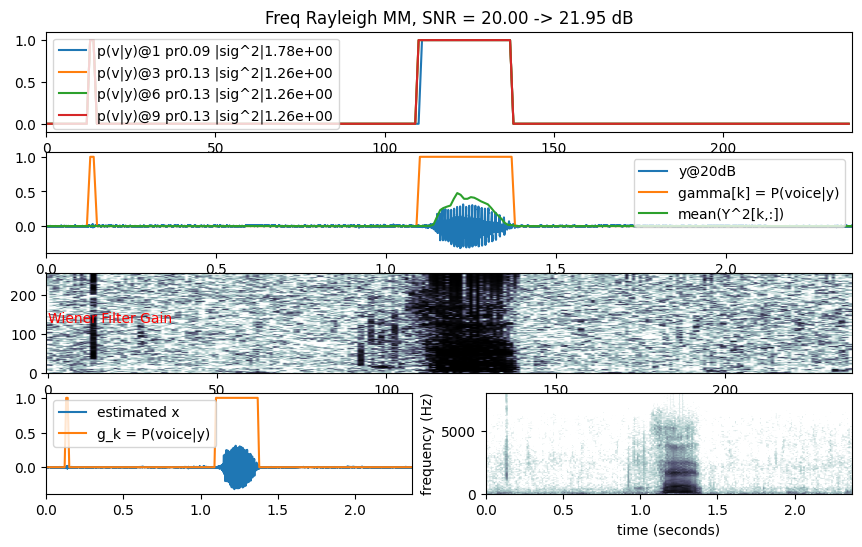

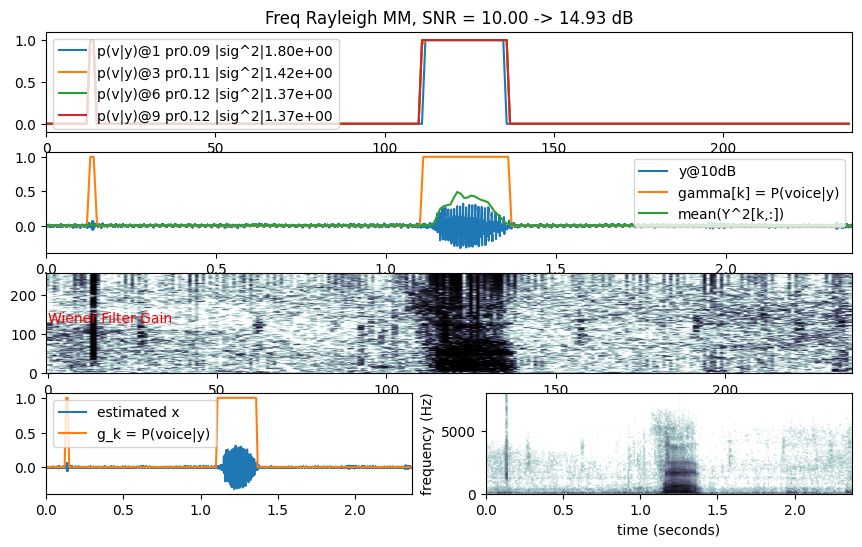

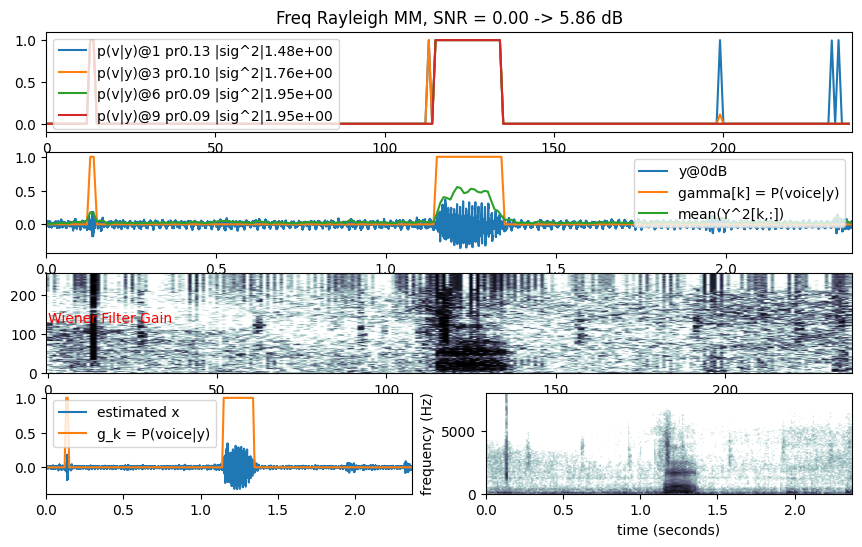

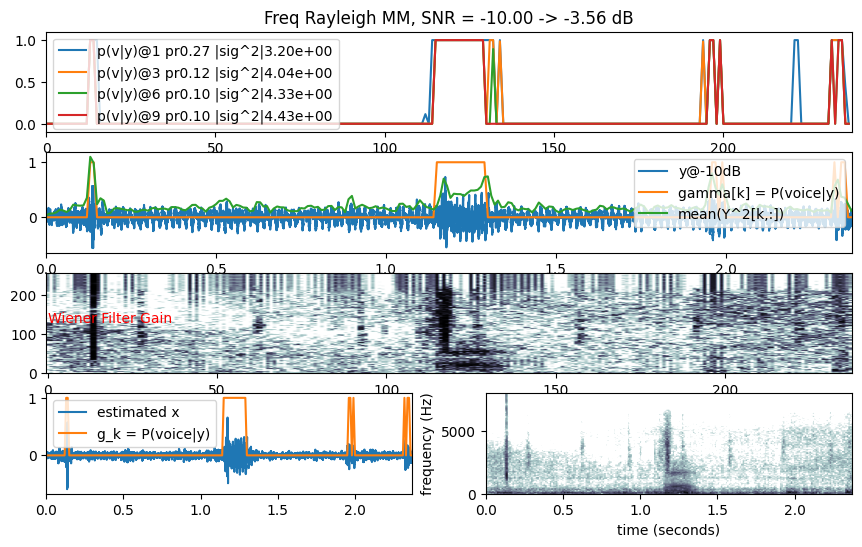

In [45]:
nsWavfiles = []
nsSig = []
for ii in range(len(mixedSig1)):
    xe, fname = doexp_vad_rayleigh(mixedSig2[ii], mixsnrs[ii], 9, 3, xtarget=speech, fname_header='wbn_rayleigh')
    nsWavfiles.append(fname)
    nsSig.append(xe)

이어폰으로 들어봐야 narrowband와 차이를 알 수 있다. 

Stationary 하지 않은 깜박이 소리는 거의 제거되지 않는다.

In [46]:
fname = nsWavfiles[0]
print(fname)
IPython.display.Audio(fname)

out/wbn_rayleigh20db.wav


In [47]:
fname = nsWavfiles[1]
print(fname)
IPython.display.Audio(fname)

out/wbn_rayleigh10db.wav


In [48]:
fname = nsWavfiles[2]
print(fname)
IPython.display.Audio(fname)

out/wbn_rayleigh0db.wav


In [49]:
fname = nsWavfiles[3]
print(fname)
IPython.display.Audio(fname)

out/wbn_rayleigh-10db.wav


.

## End of Lab 05